Course: CS4487 project  
Group 16  
Student Name: Fung Sze Man  (SID: 56344553)  
Student Name: Chiu Chun Choi (SID: 56666173)

Requirements.txt:  
torch  
torchvision  
numpy  
matplotlib==3.8.2  
tqdm==4.66.1  
efficientnet-pytorch==0.7.1  
scikit-learn==1.3.2  

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch.optim as optim
import efficientnet_pytorch
from datetime import datetime
from tqdm import tqdm
from collections import Counter

Altering the output from EffecientNet for our train/test task

In [11]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_class):
        super(CustomEfficientNet, self).__init__()
        self.base_model = efficientnet_pytorch.EfficientNet.from_pretrained(
            'efficientnet-b0'
        )
        self.base_model._fc = nn.Linear(
            in_features=self.base_model._fc.in_features, 
            out_features=num_class, 
            bias=True
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.base_model(x)
        return x

Implenment Early Stopping with patience and delta approach

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=True):
        self.patience = patience # Num of epochs to wait
        self.delta = delta # Minimum change in the monitored quantity to qualify as an improvement.
        self.verbose = verbose # print message for each validation loss improvement or not
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'./results/{train_name}/{train_name}-vloss{self.val_loss_min}.pth')
        self.val_loss_min = val_loss

If dataset is completely changed for finetuning, can use this function to calculate the mean and std again for new dataset. Otherwise can skip this cell.

In [4]:
def getmeanstd(dataroot, img_h, img_w,batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_h, img_w)),
        transforms.ToTensor()
    ])
    dataset = ImageFolder(dataroot, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize the variables for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_images = 0

    # Calculate the mean for each channel
    for images, _ in data_loader:
        num_images += images.size(0)
        mean += torch.mean(images, dim=(0, 2, 3))

    mean /= num_images

    # Calculate the standard deviation for each channel
    for images, _ in data_loader:
        std += torch.mean((images - mean.view(1, 3, 1, 1)) ** 2, dim=(0, 2, 3))

    std = torch.sqrt(std / num_images)
    print("Dataset: ", dataroot)
    print("Mean values: ", mean)
    print("Standard deviation values: ", std)
    return mean, std

Fine-tuning configurations

If you want to reproduct our best model, you can try the following config

"model_name": "efficientnet_b0"

"criterion": "BCEWithLogitsLoss"

"scheduler": "multistep"

"batch_size": 32

"learning_rate": 0.0001

In [5]:
config = {
    "model_name": "efficientnet_b0",  # "vit_l_32" or "swin_v2_b" or "efficientnet_b0"
    "criterion": "BCEWithLogitsLoss", # "BCEWithLogitsLoss" or "BCELoss" or "CELoss"
    "scheduler": "exponential", # "none" or "exponential" or "multistep"
    "pretrained": True,         # Set False for training from scratch
    "data_root": "../Dataset",
    "batch_size": 8,            # 16
    "num_epochs": 10,            # 10
    "learning_rate": 1e-5,
    "gpus": [0],               # Default is GPU 0, change to [0, 1] for both GPUs
    "output_dir": "./results",
    "early_stopping": True,
    "patience": 5,
    "delta": 0.001,
    "es_verbose": True
}

In [6]:
# Dataset and DataLoader

if config["model_name"].lower()[:3] == "vit" or config["model_name"] == "efficientnet_b0":
    transform = transforms.Compose([
        transforms.Resize((224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0291, 0.0269, 0.0253], [0.1319, 0.1239, 0.1194]),
        # to save computation cost use pre calculated mean and std here, for other datasets use getmeanstd()
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.0291, 0.0269, 0.0253], [0.1319, 0.1239, 0.1194]),
        # to save computation cost use pre calculated mean and std here, for other datasets use getmeanstd()
    ])
"""
Pre calculated mean and std on provided dataset:
Mean values:  tensor([0.0291, 0.0269, 0.0253])
Standard deviation values:  tensor([0.1319, 0.1239, 0.1194])
([0.0291, 0.0269, 0.0253]),([0.1319, 0.1239, 0.1194])
"""
train_dataset = datasets.ImageFolder(os.path.join(config["data_root"], "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(config["data_root"], "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)

initiate early stopper and load model pretrained weight

In [7]:
early_stopper = EarlyStopping(config["patience"], config["delta"], config["es_verbose"])

num_classes = len(train_dataset.classes)
out_features =  1 if num_classes < 3 else num_classes
print(out_features)

if config["model_name"].lower() == "vit_l_32":
    model = models.vit_l_32(weights=models.ViT_L_32_Weights.DEFAULT if config["pretrained"] else None)
    num_features = model.heads.head.in_features
    model.heads.head = nn.Linear(num_features, out_features)
elif config["model_name"].lower() == "swin_v2_b":
    model = models.swin_v2_b(weights=models.Swin_V2_B_Weights.DEFAULT if config["pretrained"] else None)
    num_features = model.head.in_features
    model.head = nn.Linear(num_features, out_features)
elif config["model_name"].lower() == "efficientnet_b0":
    model = CustomEfficientNet(out_features)
else:
    raise ValueError("Unsupported model")

1
Loaded pretrained weights for efficientnet-b0


In [8]:
check_dataset = train_dataset
dataset_counter = dict(Counter(check_dataset.targets))
for name, index in check_dataset.class_to_idx.items():
    print(f"{name}: {dataset_counter[index]}")

Fake: 24549
Real: 24512


In [9]:
# GPU setup
device = torch.device(f"cuda:{config['gpus'][0]}" if torch.cuda.is_available() else "cpu")
model.to(device)

if len(config["gpus"]) > 1:
    model = nn.DataParallel(model, device_ids=config["gpus"])

Select loss function according to configurations in previous cell

In [10]:
def get_criterion():
    if config["criterion"].lower() == "bcewithlogitsloss":
        return nn.BCEWithLogitsLoss()
    elif config["criterion"].lower() == "bceloss":
        return nn.BCELoss()
    elif config["criterion"].lower() == "celoss": # for multi classes
        return nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported loss function")

In [11]:
# Loss and Optimizer
criterion = get_criterion()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
scaler = GradScaler()

Select scheduler for dynamic learning_rate according to configurations in previous cell

In [12]:
# Get scheduler for dynamic learning_rate
def get_scheduler():
    if config["scheduler"] == "none":
        return None
    elif config["scheduler"] == "exponential":
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5) # lr = lr*gamma**epoch
    elif config["scheduler"] == "multistep":
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.1)
    else:
        raise ValueError("Unsupported scheduler")

In [13]:
# Training and Validation Function
def train(epoch):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [TRAIN]", leave=False)
    scheduler = get_scheduler()
    
    for i, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device).float()
        if config["criterion"].lower() == "celoss":
            labels = labels.type(torch.LongTensor).to(device)
        else:
            labels = labels.unsqueeze(1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        if config["criterion"].lower() == "celoss":
            predictions = torch.max(outputs,1).indices
        else:
            predictions = torch.sigmoid(outputs) > 0.5
        total_correct += predictions.eq(labels).sum().item()
        total_samples += labels.size(0)
        loss=total_loss/(total_samples/config["batch_size"])
        acc=total_correct/total_samples
        progress_bar.set_postfix(loss=loss, acc=acc)

    # Update scheduler
    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / total_samples
    print(f"Train Epoch: {epoch} Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc

In [14]:
def validate(epoch):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch} [VALID]", leave=False)
    with torch.no_grad():
        for i, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device).float()
            if config["criterion"].lower() == "celoss":
                labels = labels.type(torch.LongTensor).to(device)
            else:
                labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            if config["criterion"].lower() == "celoss":
                predictions = torch.max(outputs,1).indices
            else:
                predictions = torch.sigmoid(outputs) > 0.5
            total_correct += predictions.eq(labels).sum().item()
            total_samples += labels.size(0)
            loss=total_loss/(total_samples/config["batch_size"])
            acc=total_correct/total_samples
            progress_bar.set_postfix(loss=loss, acc=acc)


    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / total_samples
    print(f"Val Epoch: {epoch} Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc

In [19]:
# Logging Setup
train_name = config["model_name"]+'-'+datetime.now().strftime("%Y%m%d%H%M%S")
output_folder = os.path.join(config["output_dir"], train_name)
os.makedirs(output_folder, exist_ok=True)
log_file = os.path.join(output_folder, f"{train_name}-training_log.txt")

with open(log_file, "w") as f:
    f.write("Training Configuration:\n")
    for key, value in config.items():
        f.write(f"{key}: {value}\n")
    f.write("\n")

In [ ]:
# Training Loop
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(config["num_epochs"]):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}\n")
    
    # Update EarlyStopping and check for early stop condition
    if config["early_stopping"] == True:
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break
    
    # Logging
    with open(log_file, "a") as f:
        f.write(f"Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}\n")

In [ ]:
model_save_path = os.path.join(output_folder, f"{train_name}.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

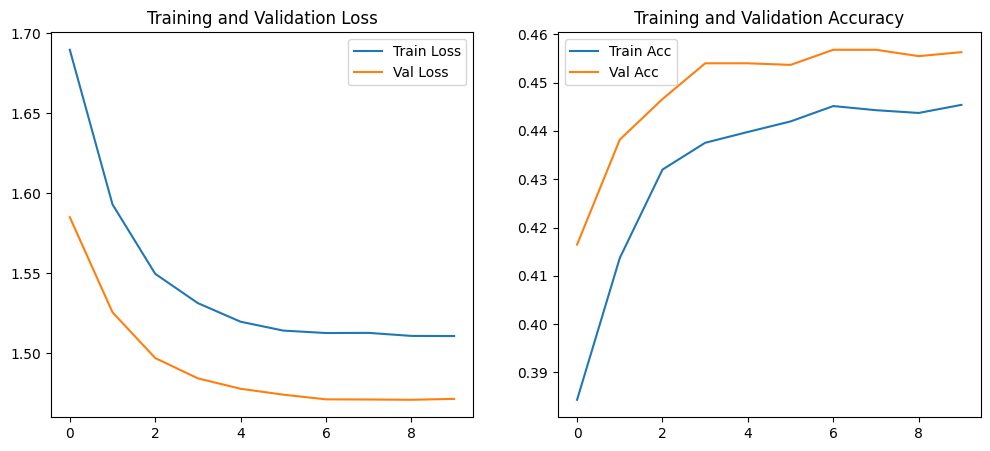

In [37]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Training and Validation Accuracy")
plt.legend()
filename = f"{train_name}-metrics.png"
plt.savefig(os.path.join(output_folder, filename))
plt.show()

# Testing the model  
please run the first 4 cells for testing setup after the following steps are done  

0. please make sure the following folder structure, create these under root dir if not exist:   
    - ./Datasets
    - ./results
1. put the model under "./results", please make sure the model_save_name is changed to the path under "./results" where the model is stored for testing and adjust other related configurations if needed 
2. put the test dataset in ./Dataset   
3. change the "val" in following line in the 4th cell below to the subfolder name containing test set e.g if the subfolder is "test" then change to "test"
"test_dataset = datasets.ImageFolder(os.path.join(test_config["data_root"], "val"), transform=transform"

In [6]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
import numpy as np
import efficientnet_pytorch

In [7]:
test_config = {
    "model_name": "efficientnet_b0",  # same as training configuration
    "batch_size": 8,  # can be different from training batch size
    "data_root": "../Dataset",  # root directory of the test dataset
    "output_dir": "./results",  # directory where the model is saved
    "gpus": [0],               # Default is GPU 0, change to [0, 1] for both GPUs
    "model_save_name": "efficientnet_b0-20231208094757/efficientnet_b0-20231208094757.pth"  # name of the saved model file
}

In [8]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_class):
        super(CustomEfficientNet, self).__init__()
        self.base_model = efficientnet_pytorch.EfficientNet.from_pretrained(
            'efficientnet-b0'
        )
        self.base_model._fc = nn.Linear(
            in_features=self.base_model._fc.in_features, 
            out_features=num_class, 
            bias=True
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.base_model(x)
        return x

load model function

In [9]:
def load_model(model_path, model, device):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

load the model with above configuration, test set, and prepare test set loader  

In [10]:
if test_config["model_name"].lower()[:3] == "vit":
    transform = transforms.Compose([
        transforms.Resize((224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0291, 0.0269, 0.0253], [0.1319, 0.1239, 0.1194]),
        # to save computation cost use pre calculated mean and std here, for other datasets use getmeanstd()
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.0291, 0.0269, 0.0253], [0.1319, 0.1239, 0.1194]),
        # to save computation cost use pre calculated mean and std here, for other datasets use getmeanstd()
    ])

test_dataset = datasets.ImageFolder(os.path.join(test_config["data_root"], "val"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_config["batch_size"], shuffle=False)

num_classes = len(test_dataset.classes)
out_features =  1 if num_classes < 3 else num_classes
print(out_features)

if test_config["model_name"].lower() == "vit_l_32":
    model = models.vit_l_32(pretrained=False)
elif test_config["model_name"].lower() == "swin_v2_b":
    model = models.swin_v2_b(pretrained=False)
elif test_config["model_name"].lower() == "efficientnet_b0":
    model = CustomEfficientNet(out_features)
else:
    raise ValueError("Unsupported model")

# GPU setup
device = torch.device(f"cuda:{test_config['gpus'][0]}" if torch.cuda.is_available() else "cpu")
model.to(device)

if len(test_config["gpus"]) > 1:
    model = nn.DataParallel(model, device_ids=test_config["gpus"])

# Load the trained model
model_path = os.path.join(test_config["output_dir"], test_config["model_save_name"])
model = load_model( model_path, model, device)

1
Loaded pretrained weights for efficientnet-b0


### The following cell is our test inference code

In [11]:
def test(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            
            # different handle for multi classes
            if out_features > 1: 
                labels = labels.type(torch.LongTensor).to(device)
            else:
                labels = labels.unsqueeze(1)

            # different handle for multi classes
            if out_features > 1:
                predictions = torch.max(outputs,1).indices
            else:
                predictions = torch.sigmoid(outputs) > 0.5
                predictions = predictions.type(torch.LongTensor).to(device)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    auc = roc_auc_score(all_labels, all_predictions)

    print(f'Test Results\n Accuracy: {accuracy:.4f},\n Recall: {recall:.4f},\n Precision: {precision:.4f},\n AUC: {auc:.4f}')
    return accuracy, recall, precision, auc

# run testing
accuracy, recall, precision, auc = test(model, test_loader)

Test Results
 Accuracy: 0.9371,
 Recall: 0.9371,
 Precision: 0.9372,
 AUC: 0.9371


# References  
lukemelas (2020) EfficientNet-PyTorch. https://github.com/lukemelas/EfficientNet-PyTorch  
  
D. A. Coccomini, N. Messina, C. Gennaro, and F. Falchi, “Combining EfficientNet and vision transformers for video deepfake detection,” Image Analysis and Processing – ICIAP 2022, pp. 219–229, 2022. doi:10.1007/978-3-031-06433-3_19   
  
Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2021). "An Image is Worth 16x16 Words: Transformers for image recognition at scale." In International Conference on Learning Representations.  
   
Ismali, F. (2023, April 3). GPT-4 explaining Self-Attention Mechanism. LinkedIn. https://www.linkedin.com/pulse/gpt-4-explaining-self-attention-mechanism-fatos-ismali/  
  
Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., ... & Guo, B. (2021). Swin Transformer: Hierarchical Vision Transformer using Shifted Windows. In International Conference on Computer Vision (pp. 4340-4349).   
  
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).   
